In [1]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve

# Functions 

## processing

In [2]:
def makeAUC(df, target_col = None):
    
    data =[i.split('_') for i in df.iloc[:,2:].columns]    
    
    return_df = pd.DataFrame(data, columns = ['FEATURE', 'TYPE'])    
    
    bins_lst = df['BIN'].unique()
    
    for b in bins_lst:
        bin_df = df[df['BIN'] == b]
        target = bin_df[target_col].values
        
        features = bin_df.iloc[:,2:]
        
        auc_lst = []
        
        for col in features.columns:

            feat = bin_df[col].values
            
            auc = roc_auc_score(target, feat)
            auc_lst.append(max(auc, 1-auc))
                
        return_df = pd.concat([return_df, pd.Series(auc_lst, name= f'{b}_AUC')], axis = 1)     
        
    std_ser = return_df.std(axis = 1)
    std_ser.name = 'STD'
    return pd.concat([return_df, std_ser],axis = 1)

In [3]:
def makeBinAnalysis(df, target_col= 'SEVERE'):
    maskResult_lst = []
    for maskNumber in range(1,9):
        aux_df = df[df['MASK'] == maskNumber].iloc[:,2:]
        aux_df = makeAUC(aux_df, target_col)
        mask_ser = pd.Series(np.zeros(len(aux_df))+maskNumber, name = 'MASK')
        
        maskResult_lst.append(pd.concat([aux_df, mask_ser],axis = 1))
    
    finalData = pd.concat(maskResult_lst)
    finalData['MASK'] = finalData['MASK'].astype(int)
    
    return finalData.reset_index(drop = True)

## Images 

In [4]:
def makeFeaturePlot(data, maskNumber = '1'):
    
    groupType = ['FO', 'GLCM', 'GLSZM', 'GLRLM', 'NGTDM', 'GLDM']    

    dataMask1 = data[data["MASK"] == maskNumber]

    featPlot_lst = []

    for group in groupType: 
        selected_col = [col for col in dataMask1.columns if group in col]
        featPlot_lst.extend(dataMask1[selected_col].std(axis=0).sort_values(ascending = False).index[:4])

    row = 6
    col = 4
    fig, axs = plt.subplots(row,col, figsize = (20,20))


    for ax, feat in zip(axs.flatten(),featPlot_lst):
        g = sns.stripplot(x="BIN", y=feat, palette="pastel",
                      data=dataMask1, dodge=True, alpha=.15, zorder=1, ax = ax)

        sns.pointplot(x="BIN", y=feat, palette="dark",
                      data=dataMask1, dodge=.532, join=False, 
                      markers="d", scale=.75, ci=None, ax = ax)

        aux_lst = feat.split('_')
        g.set_title(aux_lst[0],fontsize = 15)
        g.set_yticklabels([])
        g.set_ylabel(aux_lst[1],fontsize = 15)

    plt.tight_layout()
    plt.ticklabel_format()
    plt.savefig(os.path.join(os.getcwd(), 'figures', 'analysisBin','featurePlot',f'features_bin_Mask{maskNumber}.png'), format = 'png')
    plt.show()

In [5]:
def makeBoxPlot(data, bestFeatures_lst, binNumber):
    
    fig, axs = plt.subplots(5,2, figsize = (16,20))

    aux = data[data['BIN'] == binNumber]

    for ax, col in zip(axs.flatten(),  bestFeatures_lst[1:]):

        sns.boxplot(x= 'MASK',y=col, hue = 'SEVERE', data=aux, ax=ax)

        col_lst=col.split('_')
        ax.set_title(f'{col_lst[0]} ({col_lst[1]})')
        #g.set_yticklabels([])
        ax.set_ylabel(None, fontsize = 15)

    plt.tight_layout()
    plt.ticklabel_format()
    plt.savefig(os.path.join(os.getcwd(), 'figures', 'analysisBin', 'box_plot', f'bestFeat_bin{binNumber}.png'), format = 'png')
    plt.show()

In [6]:
def makeROC(bestData, bestFeatures_lst):
    fig, axs = plt.subplots(5,2, figsize = (12,16))

    y_target = bestData['SEVERE']

    for ax, col in zip(axs.flatten(), bestFeatures_lst[1:]):

        fpr, tpr, thresholds = roc_curve(y_target, bestData[col])

        auc = roc_auc_score(y_target, bestData[col])
        auc = max(auc, 1-auc)
        ax.plot(fpr, tpr,label=f'AUC = {round(auc,2)}', c= 'b')

        aux=col.split('_')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_title(f'{aux[0]} ({aux[1]})')
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")

        ax.legend()

    plt.tight_layout()
    plt.ticklabel_format()
    plt.savefig(os.path.join(os.getcwd(), 'figures', 'analysisBin', 'roc_curve', f'mask{maskNumber}_bin{binNumber}.png'), format = 'png')
    plt.show()

# Loading Data 

In [7]:
os.chdir('..')

In [8]:
data = pd.read_parquet(os.path.join(os.getcwd(), 'data','modelData', 'modelData.parquet'))

# Feature Analysis

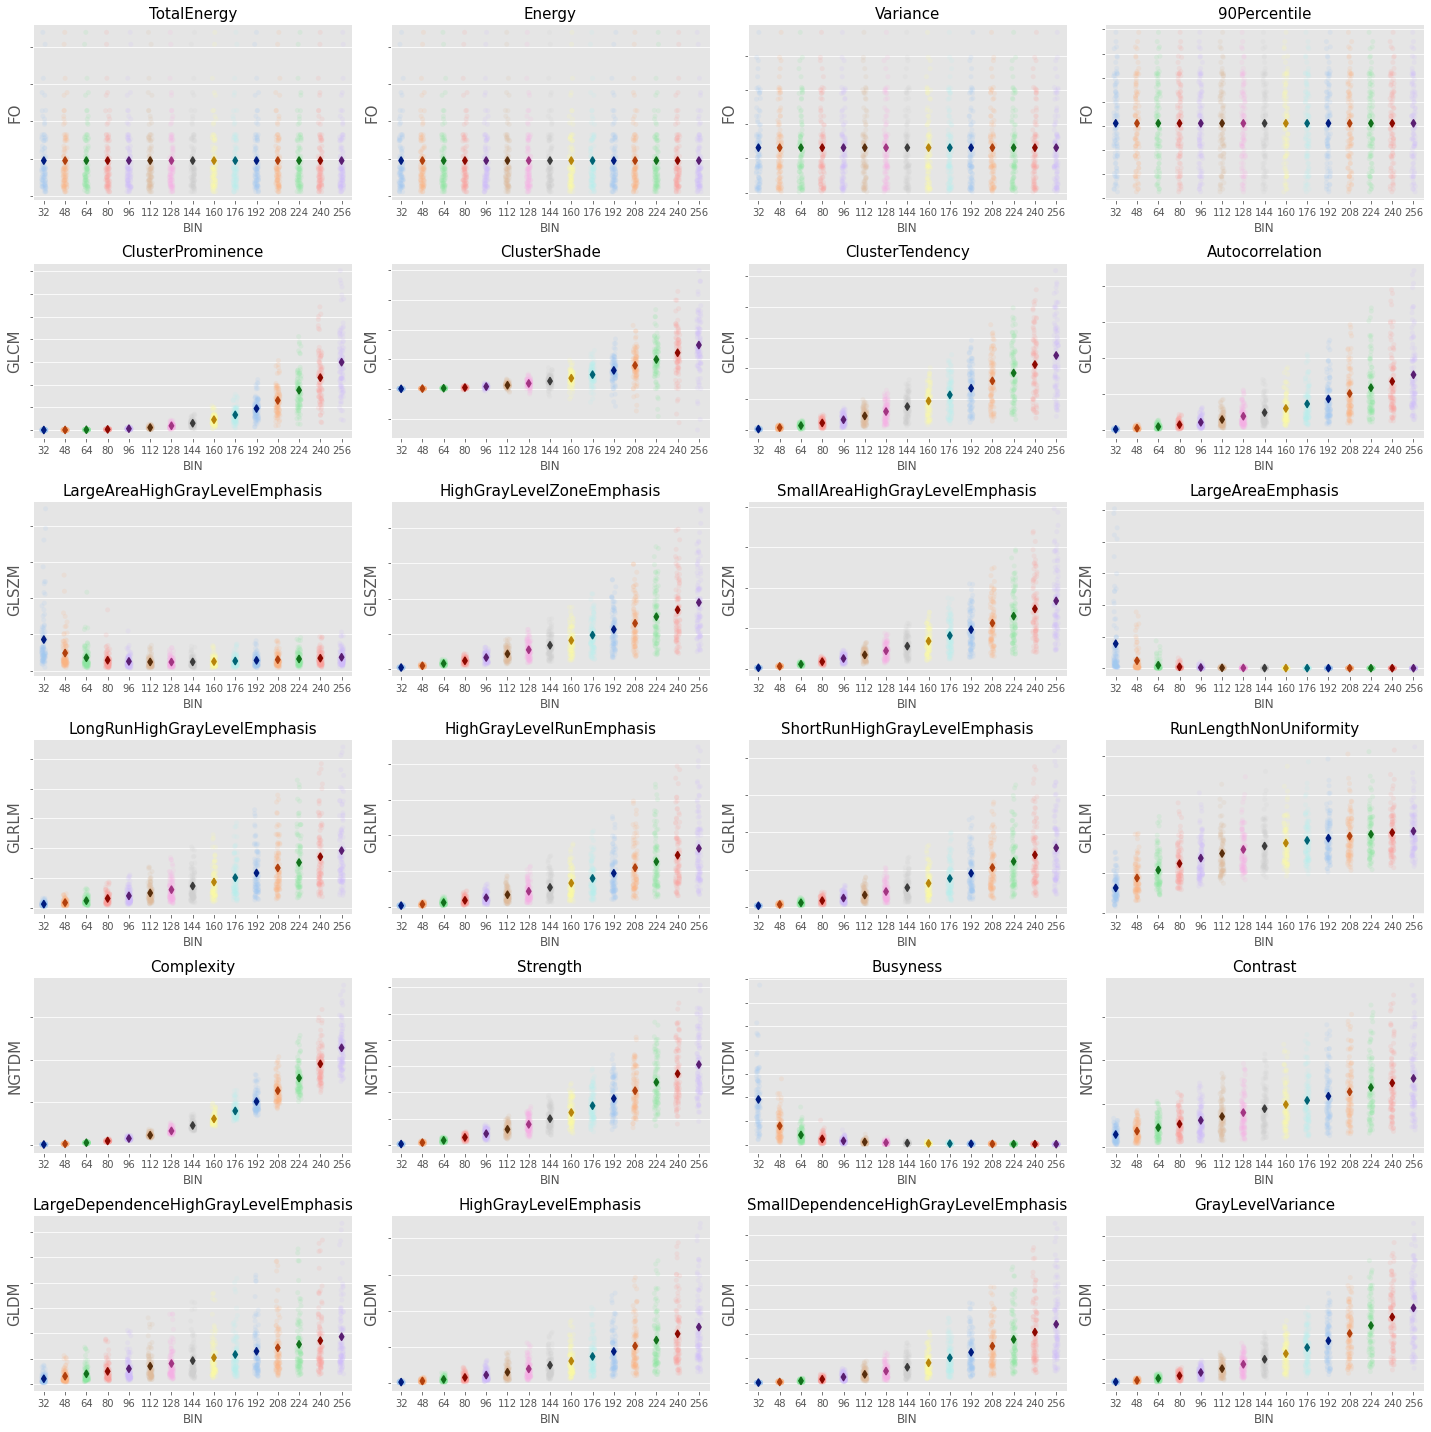

In [9]:
makeFeaturePlot(data, 1)

# Bin AUC Analysis 

In [10]:
results = makeBinAnalysis(data)

Average of the standard deviations for every bin size for each feature group and the respective mask.

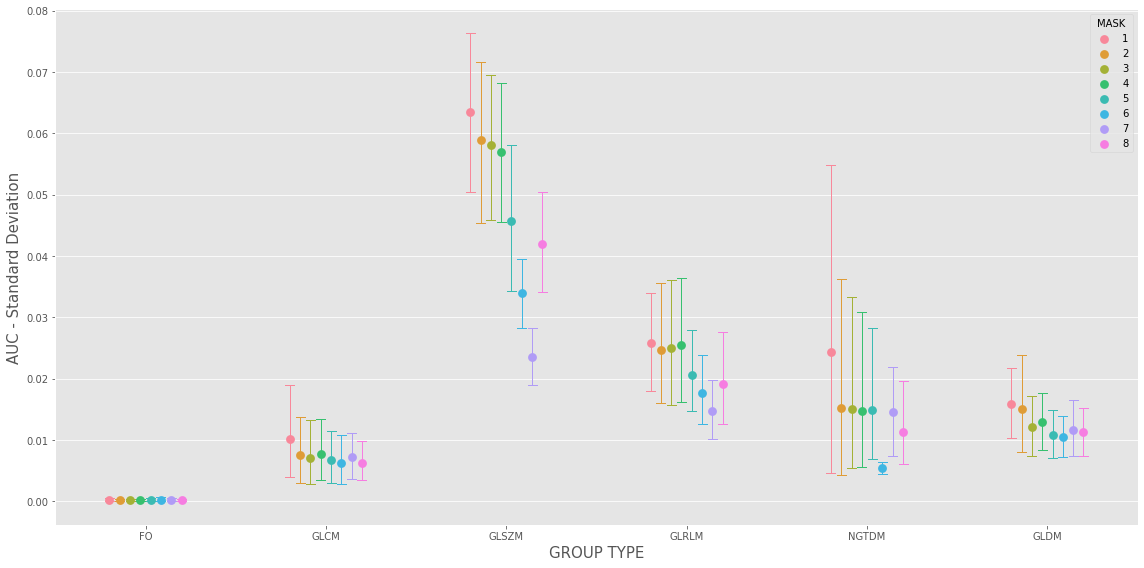

In [11]:
plt.figure( figsize = (16,8) )
ax = sns.pointplot(x="TYPE", y="STD", 
                   data=results, 
                   seed = 42,
                   errwidth = 1,
                   capsize= 0.05,
                   join=False,
                   dodge=0.4,
                   estimator= np.mean, hue = 'MASK')
ax.set_ylabel('AUC - Standard Deviation',fontsize = 15)
ax.set_xlabel('GROUP TYPE',fontsize = 15)
plt.tight_layout()
plt.ticklabel_format()
plt.savefig(os.path.join(os.getcwd(), 'figures', 'analysisBin',f'auc_bin_StdAnalysis.png'), format = 'png')

# Best AUC analysis

Approximately 47% of the features had a better score with 32 bin.

In [12]:
results.iloc[:,2:-2].idxmax(axis = 1).value_counts()/len(results)

32_AUC     0.467742
48_AUC     0.112903
256_AUC    0.104839
80_AUC     0.051075
64_AUC     0.040323
240_AUC    0.040323
112_AUC    0.033602
224_AUC    0.032258
208_AUC    0.025538
144_AUC    0.018817
128_AUC    0.018817
176_AUC    0.017473
96_AUC     0.017473
160_AUC    0.010753
192_AUC    0.008065
dtype: float64

Of the 50 best features 62% belong to mask 1 and 34% belong to mask 2.

In [13]:
bestAUC_df = results.nlargest(50, results.iloc[:,2:-2].columns, keep='all')
bestAUC_df.reset_index(drop = True,inplace = True)

In [14]:
bestAUC_df.groupby('MASK')['FEATURE'].count()/50

MASK
1    0.62
2    0.34
3    0.02
4    0.02
Name: FEATURE, dtype: float64

Of the 50 best AUC 38% belong to FO, 24% to GLCM, 0.14 to NGTDM, 0.12 to GLDM and GLRLM.    

In [15]:
bestAUC_df.groupby('TYPE')['FEATURE'].count()/50
#The group GLSZM is missing 
#['FO', 'GLCM', 'GLSZM', 'GLRLM', 'NGTDM', 'GLDM']  

TYPE
FO       0.38
GLCM     0.24
GLDM     0.12
GLRLM    0.12
NGTDM    0.14
Name: FEATURE, dtype: float64

# The 10 best features analysis

For MASK 1 and BIN 32

In [16]:
maskNumber = 1
binNumber = 32

In [17]:
results_mask1 = results[results['MASK'] == int(maskNumber) ]
bestAUC_df = results_mask1.nlargest(10, results.iloc[:,2:-2].columns, keep='all')
bestAUC_df.reset_index(drop = True, inplace = True)

bestFeatures_lst=bestAUC_df[['FEATURE','TYPE']].apply(lambda x: '_'.join(x),axis = 1).tolist()
bestFeatures_lst.insert(0,'SEVERE')

In [18]:
cond1 = (data['MASK'] == maskNumber)
cond2 = (data['BIN']  == binNumber)

bestData = data[cond1 & cond2]
bestData.reset_index(drop =True, inplace =True)
bestData = bestData[bestFeatures_lst]

## Boxplot

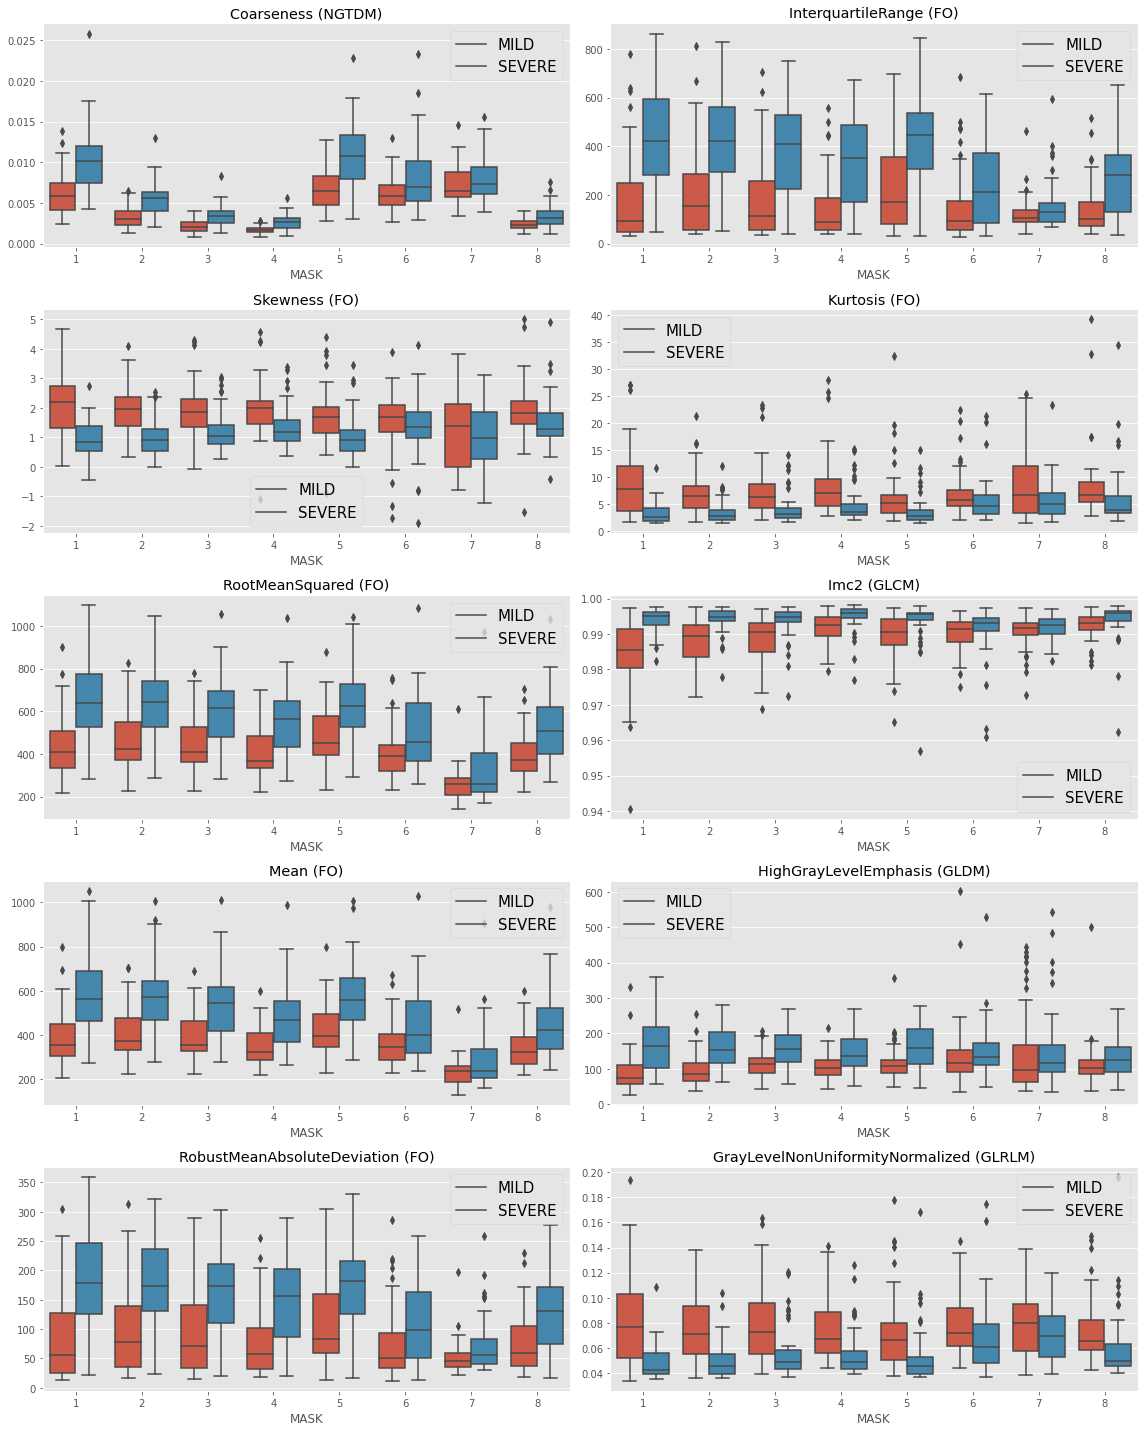

In [19]:
makeBoxPlot(data,bestFeatures_lst,binNumber)

## ROC Curve

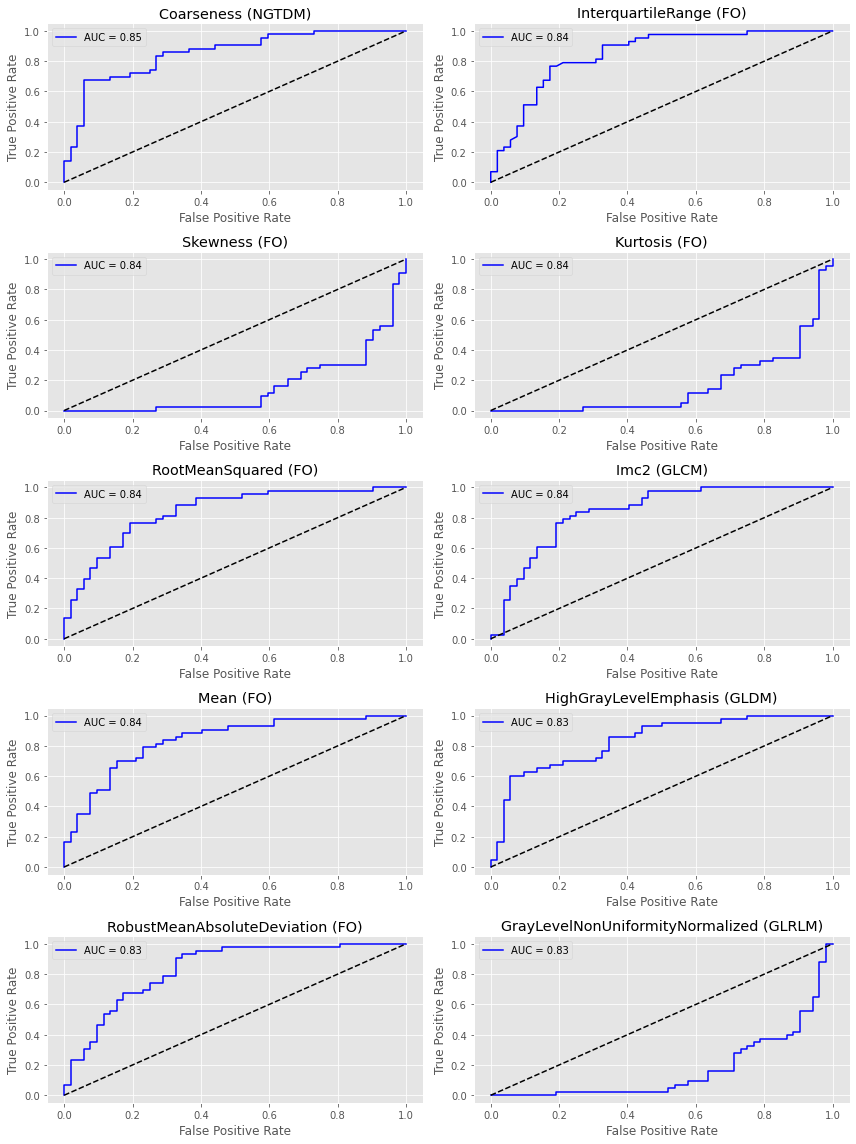

In [20]:
makeROC(bestData,bestFeatures_lst)